In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import csv
from csv import writer



#tensorflow import
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.optimizers import Adam


#custom functions import
from ts_functions import time_window_generator
from aux_functions import aux_functions


mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

e:\anaconda\envs\tf\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#option flags
debug_mode = True
debug_output_n = 2

performance_log = True
data_log_csv_path = "training_log/sm_ma_gc.csv"

In [3]:
fileDir = os.path.dirname(os.path.realpath('__file__'))
filename = os.path.join(fileDir, r"stock_data\index300_01_22_day.csv")

In [4]:
df = pd.read_csv(filename)

In [5]:
if debug_mode:
    display(df)

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,600959.SH,20220825,3.11,3.15,3.08,3.14,3.10,0.04,1.2903,257244.98,80210.0830
1,600959.SH,20220824,3.13,3.16,3.10,3.10,3.13,-0.03,-0.9585,298446.31,93501.1140
2,600959.SH,20220823,3.13,3.15,3.12,3.13,3.15,-0.02,-0.6349,154322.30,48370.6290
3,600959.SH,20220822,3.10,3.16,3.08,3.15,3.10,0.05,1.6129,280632.29,87907.3130
4,600959.SH,20220819,3.10,3.14,3.09,3.10,3.09,0.01,0.3236,259713.32,80904.7100
...,...,...,...,...,...,...,...,...,...,...,...
1910516,000860.SZ,20010905,11.55,11.72,11.52,11.57,11.50,0.07,0.6100,2490.95,2896.0381
1910517,000860.SZ,20010904,11.21,11.52,11.21,11.50,11.23,0.27,2.4000,1883.77,2149.8242
1910518,000860.SZ,20010903,11.38,11.40,11.20,11.23,11.39,-0.16,-1.4000,1002.70,1133.6562
1910519,000860.SZ,20010831,11.50,11.55,11.38,11.39,11.47,-0.08,-0.7000,803.44,917.1637


In [6]:
if debug_mode:
    display(df.describe())

,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
count,1.910521e+06,1.910521e+06,1.910521e+06,1.910521e+06,1.910521e+06,1.910521e+06,1.910521e+06,1.910521e+06,1.910521e+06,1.910521e+06
mean,2.013566e+07,2.237008e+01,2.286003e+01,2.192832e+01,2.240204e+01,2.238382e+01,1.822791e-02,8.703455e-02,2.751701e+05,3.693597e+05
std,5.881290e+04,5.151581e+01,5.257824e+01,5.054839e+01,5.159443e+01,5.154553e+01,1.732856e+00,3.346965e+00,6.962850e+05,8.190276e+05
min,2.001010e+07,1.700000e-01,1.800000e-01,1.600000e-01,1.700000e-01,1.700000e-01,-2.099900e+02,-4.906000e+01,5.000000e+00,1.872000e+00
25%,2.009081e+07,6.700000e+00,6.820000e+00,6.590000e+00,6.700000e+00,6.700000e+00,-1.500000e-01,-1.312300e+00,3.035923e+04,4.030214e+04
50%,2.014101e+07,1.196000e+01,1.219000e+01,1.175000e+01,1.197000e+01,1.197000e+01,0.000000e+00,0.000000e+00,9.623809e+04,1.302846e+05
75%,2.019021e+07,2.270000e+01,2.317000e+01,2.225000e+01,2.272000e+01,2.271000e+01,1.600000e-01,1.350000e+00,2.658852e+05,3.605996e+05
max,2.022082e+07,2.587980e+03,2.627880e+03,2.485000e+03,2.601000e+03,2.601000e+03,2.289800e+02,1.356250e+03,5.135467e+07,6.999139e+07


# Model DataFrame preprocessing

In [7]:
#split data into different stock
stock_list = [x.sort_values("trade_date", ascending = True) for _,x in df.groupby('ts_code')]
#sort by trade_date, ascending
if debug_mode:
    print("number of stocks : ", len(stock_list))

number of stocks :  577


# add time periodicity

In [8]:
#setup timestamp for year periodicity 
date_time_db = []

for stock_i in stock_list:
    date_time_db.append(pd.to_datetime(stock_i.pop('trade_date'), format='%Y%m%d'))

In [9]:
if debug_mode:
    print(date_time_db[0])

314360   2001-05-29
314359   2001-05-30
314358   2001-05-31
314357   2001-06-01
314356   2001-06-04
            ...    
309365   2022-08-19
309364   2022-08-22
309363   2022-08-23
309362   2022-08-24
309361   2022-08-25
Name: trade_date, Length: 5000, dtype: datetime64[ns]


In [10]:
date_time_stamp_db = []

for dt in date_time_db:
    date_time_stamp_db.append(dt.map(pd.Timestamp.timestamp))

In [11]:
if debug_mode:
    date_time_stamp_db[0]

In [12]:
year = 24*60*60*(365.2425)

for i in range(len(stock_list)):
    
    stock_list[i]["Year sin"] = np.sin(date_time_stamp_db[i] * (2 * np.pi / year))
    stock_list[i]["Year cos"] = np.cos(date_time_stamp_db[i] * (2 * np.pi / year))
    

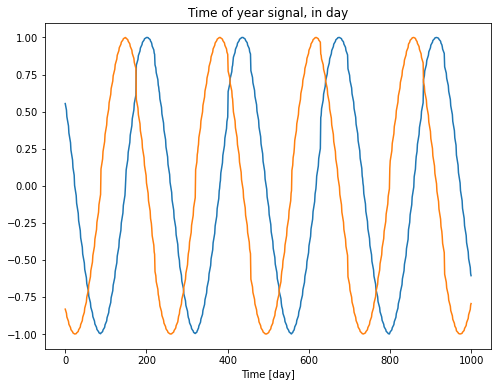

In [13]:
if debug_mode:
    plt.plot(np.array(stock_list[0]['Year sin'])[:1000])
    plt.plot(np.array(stock_list[0]['Year cos'])[:1000])
    plt.xlabel('Time [day]')
    plt.title('Time of year signal, in day')

In [14]:
if debug_mode:
    stock_list[5].head()

In [15]:
#df processing
for stock in stock_list:
    stock.name = stock.iloc[0,0]
    stock.pop("ts_code") #pop the stock code
    stock.pop("pre_close") #pop previous day close price

In [16]:
if debug_mode:
    stock_list[0].head()

# MA implementation

In [17]:
ma_label = 'open'

In [18]:
for stock in stock_list:
    
    #MA

    processing_row = stock[ma_label].to_frame()

    stock['sma5'] = processing_row[ma_label].rolling(5).mean()

    stock['ema5'] = processing_row[ma_label].ewm(span=5).mean()

    stock['ema20'] = processing_row[ma_label].ewm(span=20).mean()

    stock['ema50'] = processing_row[ma_label].ewm(span=50).mean()



    #golden cross

    stock['ema20_50_GC'] = np.where(stock['ema20'] > stock['ema50'], 1, 0)


    stock.dropna(inplace=True)
    

In [19]:
display(stock_list[0])

,open,high,low,close,change,pct_chg,vol,amount,Year sin,Year cos,sma5,ema5,ema20,ema50,ema20_50_GC
314356,16.32,16.43,16.02,16.08,-0.22,-1.3500,54364.96,8.782524e+04,0.465381,-0.885111,16.122,16.209479,16.146289,16.131847,1
314355,16.06,16.19,15.86,15.91,-0.17,-1.0600,52559.38,8.380886e+04,0.450086,-0.892985,16.162,16.154857,16.128086,16.118644,1
314354,15.91,16.08,15.85,15.92,0.01,0.0600,43113.66,6.873000e+04,0.434659,-0.900595,16.168,16.068164,16.086851,16.085144,1
314353,15.92,16.00,15.79,15.84,-0.08,-0.5000,52996.08,8.403397e+04,0.419102,-0.907939,16.082,16.016771,16.058010,16.061498,0
314352,15.83,15.87,15.51,15.73,-0.11,-0.6900,38217.87,6.004657e+04,0.403422,-0.915014,16.008,15.952851,16.021436,16.031473,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309365,12.27,12.75,12.23,12.57,0.32,2.6122,2106417.24,2.653471e+06,-0.732342,-0.680937,12.260,12.274634,12.512635,13.229321,0
309364,12.58,12.68,12.41,12.50,-0.07,-0.5569,1138076.58,1.423362e+06,-0.766493,-0.642252,12.318,12.376423,12.519051,13.203858,0
309363,12.45,12.49,12.28,12.34,-0.16,-1.2800,921463.07,1.137300e+06,-0.777428,-0.628972,12.386,12.400949,12.512474,13.174295,0
309362,12.33,12.54,12.33,12.40,0.06,0.4862,1295375.33,1.613310e+06,-0.788133,-0.615506,12.422,12.377299,12.495096,13.141185,0


# Final data check

In [20]:
display(stock_list[0])
display(stock_list[50])

,open,high,low,close,change,pct_chg,vol,amount,Year sin,Year cos,sma5,ema5,ema20,ema50,ema20_50_GC
314356,16.32,16.43,16.02,16.08,-0.22,-1.3500,54364.96,8.782524e+04,0.465381,-0.885111,16.122,16.209479,16.146289,16.131847,1
314355,16.06,16.19,15.86,15.91,-0.17,-1.0600,52559.38,8.380886e+04,0.450086,-0.892985,16.162,16.154857,16.128086,16.118644,1
314354,15.91,16.08,15.85,15.92,0.01,0.0600,43113.66,6.873000e+04,0.434659,-0.900595,16.168,16.068164,16.086851,16.085144,1
314353,15.92,16.00,15.79,15.84,-0.08,-0.5000,52996.08,8.403397e+04,0.419102,-0.907939,16.082,16.016771,16.058010,16.061498,0
314352,15.83,15.87,15.51,15.73,-0.11,-0.6900,38217.87,6.004657e+04,0.403422,-0.915014,16.008,15.952851,16.021436,16.031473,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309365,12.27,12.75,12.23,12.57,0.32,2.6122,2106417.24,2.653471e+06,-0.732342,-0.680937,12.260,12.274634,12.512635,13.229321,0
309364,12.58,12.68,12.41,12.50,-0.07,-0.5569,1138076.58,1.423362e+06,-0.766493,-0.642252,12.318,12.376423,12.519051,13.203858,0
309363,12.45,12.49,12.28,12.34,-0.16,-1.2800,921463.07,1.137300e+06,-0.777428,-0.628972,12.386,12.400949,12.512474,13.174295,0
309362,12.33,12.54,12.33,12.40,0.06,0.4862,1295375.33,1.613310e+06,-0.788133,-0.615506,12.422,12.377299,12.495096,13.141185,0


,open,high,low,close,change,pct_chg,vol,amount,Year sin,Year cos,sma5,ema5,ema20,ema50,ema20_50_GC
1686131,17.36,17.37,16.81,16.83,-0.55,-3.1600,4478.16,7615.4939,0.128365,0.991727,17.448,17.398768,17.435277,17.442934,0
1686130,16.75,17.00,16.70,16.90,0.07,0.4200,1840.92,3103.0226,0.145405,0.989372,17.298,17.161699,17.290715,17.315595,0
1686129,17.00,17.20,16.80,17.00,0.10,0.5900,2132.79,3618.6299,0.162403,0.986725,17.178,17.104449,17.235748,17.264923,0
1686128,16.81,17.00,16.81,16.88,-0.12,-0.7100,1723.08,2909.1580,0.179352,0.983785,17.034,17.002314,17.162155,17.199785,0
1686127,16.88,16.90,16.57,16.61,-0.27,-1.6000,2447.59,4074.8680,0.196249,0.980554,16.960,16.960454,17.116896,17.158309,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1681258,15.05,15.14,14.82,14.82,-0.23,-1.5282,61757.68,92346.9190,-0.732342,-0.680937,15.024,15.020745,14.811555,14.713854,1
1681257,14.79,14.90,14.72,14.75,-0.07,-0.4723,47725.35,70567.6840,-0.766493,-0.642252,15.034,14.943830,14.809502,14.716840,1
1681256,14.79,15.03,14.70,14.84,0.09,0.6102,49639.05,73562.6530,-0.777428,-0.628972,15.002,14.892554,14.807645,14.719709,1
1681255,14.85,15.08,14.47,14.53,-0.31,-2.0889,83996.56,123999.9990,-0.788133,-0.615506,14.982,14.878369,14.811679,14.724818,1


# Models Area

In [21]:
stacked_lstm_1 = Sequential(

    [

        LSTM(units = 32, activation='tanh', return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01) ),
        LSTM(units = 32, activation='tanh', return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.01) ),
        Dense(units = 16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01) ),
        Dense(units = 1, activation = 'linear') #output 

    ],

    name = "simple_stacked_lstm_stock_1"

)

In [22]:
stacked_lstm_1_plus = Sequential(

    [

        LSTM(units = 64, activation='tanh', return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01) ),
        LSTM(units = 64, activation='tanh', return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.01) ),
        Dense(units = 24, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01) ),
        Dense(units = 8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01) ),
        Dense(units = 1, activation = 'linear') #output 

    ],

    name = "simple_stacked_lstm_stock_1_plus"

)

# Training for all models

In [23]:
#data storage
evaluation_result = {}


#meta data
labels = ['open']

eval_iteration = 10 #the number of evaluation iterations for individual stock

df instances :  4996
df features :  15


,open,high,low,close,change,pct_chg,vol,amount,Year sin,Year cos,sma5,ema5,ema20,ema50,ema20_50_GC
314356,16.32,16.43,16.02,16.08,-0.22,-1.3500,54364.96,8.782524e+04,0.465381,-0.885111,16.122,16.209479,16.146289,16.131847,1
314355,16.06,16.19,15.86,15.91,-0.17,-1.0600,52559.38,8.380886e+04,0.450086,-0.892985,16.162,16.154857,16.128086,16.118644,1
314354,15.91,16.08,15.85,15.92,0.01,0.0600,43113.66,6.873000e+04,0.434659,-0.900595,16.168,16.068164,16.086851,16.085144,1
314353,15.92,16.00,15.79,15.84,-0.08,-0.5000,52996.08,8.403397e+04,0.419102,-0.907939,16.082,16.016771,16.058010,16.061498,0
314352,15.83,15.87,15.51,15.73,-0.11,-0.6900,38217.87,6.004657e+04,0.403422,-0.915014,16.008,15.952851,16.021436,16.031473,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309365,12.27,12.75,12.23,12.57,0.32,2.6122,2106417.24,2.653471e+06,-0.732342,-0.680937,12.260,12.274634,12.512635,13.229321,0
309364,12.58,12.68,12.41,12.50,-0.07,-0.5569,1138076.58,1.423362e+06,-0.766493,-0.642252,12.318,12.376423,12.519051,13.203858,0
309363,12.45,12.49,12.28,12.34,-0.16,-1.2800,921463.07,1.137300e+06,-0.777428,-0.628972,12.386,12.400949,12.512474,13.174295,0
309362,12.33,12.54,12.33,12.40,0.06,0.4862,1295375.33,1.613310e+06,-0.788133,-0.615506,12.422,12.377299,12.495096,13.141185,0


train_df instances :  3497


,open,high,low,close,change,pct_chg,vol,amount,Year sin,Year cos,sma5,ema5,ema20,ema50,ema20_50_GC
314356,16.32,16.43,16.02,16.08,-0.22,-1.35,54364.96,87825.2417,0.465381,-0.885111,16.122,16.209479,16.146289,16.131847,1
314355,16.06,16.19,15.86,15.91,-0.17,-1.06,52559.38,83808.8582,0.450086,-0.892985,16.162,16.154857,16.128086,16.118644,1
314354,15.91,16.08,15.85,15.92,0.01,0.06,43113.66,68730.0042,0.434659,-0.900595,16.168,16.068164,16.086851,16.085144,1
314353,15.92,16.00,15.79,15.84,-0.08,-0.50,52996.08,84033.9660,0.419102,-0.907939,16.082,16.016771,16.058010,16.061498,0
314352,15.83,15.87,15.51,15.73,-0.11,-0.69,38217.87,60046.5733,0.403422,-0.915014,16.008,15.952851,16.021436,16.031473,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310864,8.67,8.70,8.63,8.66,-0.07,-0.80,335614.22,290490.4070,0.150403,-0.988625,8.608,8.778539,9.592944,10.053382,0
310863,8.64,8.70,8.52,8.57,-0.09,-1.04,427664.09,367771.0539,0.133374,-0.991066,8.622,8.732359,9.502188,9.997956,0
310862,8.57,8.64,8.54,8.61,0.04,0.47,325214.18,280044.0732,0.082072,-0.996626,8.618,8.678239,9.413408,9.941957,0
310861,8.58,8.64,8.56,8.63,0.02,0.23,336519.28,289122.2140,0.064916,-0.997891,8.612,8.645493,9.334036,9.888547,0






val_df instances :  999


,open,high,low,close,change,pct_chg,vol,amount,Year sin,Year cos,sma5,ema5,ema20,ema50,ema20_50_GC
310859,8.69,8.74,8.66,8.70,0.01,0.1200,362204.87,3.150519e+05,0.030552,-0.999533,8.622,8.656886,9.212034,9.794126,0
310858,8.69,8.73,8.68,8.71,0.01,0.1100,348930.19,3.036524e+05,0.013353,-0.999911,8.632,8.667924,9.162316,9.750827,0
310857,8.69,8.86,8.67,8.81,0.10,1.1500,608257.12,5.346569e+05,-0.038245,-0.999268,8.656,8.675283,9.117334,9.709226,0
310856,8.80,8.83,8.77,8.81,0.00,0.0000,422037.29,3.714228e+05,-0.055429,-0.998463,8.700,8.716855,9.087111,9.673570,0
310855,8.80,8.82,8.76,8.79,-0.02,-0.2300,322950.17,2.838274e+05,-0.072596,-0.997361,8.734,8.744570,9.059768,9.639312,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309865,13.50,13.51,13.37,13.37,-0.17,-1.2555,964067.63,1.294445e+06,-0.467131,-0.884188,13.566,13.611345,13.984323,13.833630,1
309864,13.28,13.53,13.25,13.34,-0.03,-0.2244,1165821.91,1.559068e+06,-0.482271,-0.876022,13.428,13.500897,13.917245,13.811919,1
309863,13.47,13.62,13.43,13.59,0.25,1.8741,1445096.16,1.954607e+06,-0.526819,-0.849977,13.388,13.490598,13.874650,13.798510,1
309862,13.66,14.15,13.48,14.04,0.45,3.3113,2445663.25,3.388510e+06,-0.541363,-0.840789,13.452,13.547065,13.854207,13.793079,1






val_df instances :  500


,open,high,low,close,change,pct_chg,vol,amount,Year sin,Year cos,sma5,ema5,ema20,ema50,ema20_50_GC
309860,13.82,13.96,13.65,13.90,0.14,1.0174,1352510.68,1868047.342,-0.569964,-0.821669,13.610,13.698696,13.848002,13.795149,1
309859,13.80,13.90,13.62,13.70,-0.20,-1.4388,988678.37,1356305.781,-0.584014,-0.811743,13.714,13.732464,13.843430,13.795339,1
309858,13.67,14.02,13.62,13.95,0.25,1.8248,1587710.35,2208568.316,-0.625111,-0.780536,13.754,13.711643,13.826913,13.790424,1
309857,13.97,14.66,13.97,14.13,0.18,1.2903,2603307.89,3748036.828,-0.638445,-0.769667,13.816,13.797762,13.840540,13.797466,1
309856,14.21,14.50,14.15,14.38,0.25,1.7693,1596811.70,2287731.088,-0.651590,-0.758571,13.894,13.935174,13.875727,13.813644,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309365,12.27,12.75,12.23,12.57,0.32,2.6122,2106417.24,2653471.090,-0.732342,-0.680937,12.260,12.274634,12.512635,13.229321,0
309364,12.58,12.68,12.41,12.50,-0.07,-0.5569,1138076.58,1423361.879,-0.766493,-0.642252,12.318,12.376423,12.519051,13.203858,0
309363,12.45,12.49,12.28,12.34,-0.16,-1.2800,921463.07,1137300.431,-0.777428,-0.628972,12.386,12.400949,12.512474,13.174295,0
309362,12.33,12.54,12.33,12.40,0.06,0.4862,1295375.33,1613309.589,-0.788133,-0.615506,12.422,12.377299,12.495096,13.141185,0


Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['open']
(TensorSpec(shape=(None, 6, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))
Inputs shape (batch, time, features): (8, 6, 15)
Labels shape (batch, time, features): (8, 1, 1)
Epoch 1/20
437/437 [==============================] - 11s 14ms/step - loss: 0.4262 - mean_absolute_percentage_error: 38.3695 - val_loss: 0.1287 - val_mean_absolute_percentage_error: 70.6139
Epoch 2/20
437/437 [==============================] - 5s 12ms/step - loss: 0.0909 - mean_absolute_percentage_error: 24.8399 - val_loss: 0.0495 - val_mean_absolute_percentage_error: 64.7182
Epoch 3/20
437/437 [==============================] - 5s 13ms/step - loss: 0.0490 - mean_absolute_percentage_error: 24.7745 - val_loss: 0.0301 - val_mean_absolute_percentage_error: 73.6754
Epoch 4/20
437/437 [==============================] - 5s 12ms/step - loss: 0.0337 - mean_absolute_percentage_er

,open,high,low,close,change,pct_chg,vol,amount,Year sin,Year cos,sma5,ema5,ema20,ema50,ema20_50_GC
552164,14.17,14.35,14.07,14.16,-0.01,-0.0700,14944.84,2.121055e+04,0.958389,0.285464,14.294,14.255877,14.284167,14.290071,0
552163,14.16,14.50,14.10,14.45,0.29,2.0500,31592.08,4.528077e+04,0.971839,0.235645,14.256,14.220842,14.257974,14.266168,0
552162,14.60,14.70,14.50,14.58,0.13,0.9000,41809.77,6.105285e+04,0.975749,0.218893,14.284,14.355085,14.322642,14.319768,1
552161,14.85,15.15,14.80,14.92,0.34,2.3300,97003.67,1.454917e+05,0.982701,0.185198,14.422,14.526755,14.413799,14.395689,1
552160,15.00,15.05,14.40,14.42,-0.50,-3.3500,85036.84,1.253860e+05,0.985742,0.168267,14.556,14.688716,14.507828,14.474068,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547173,16.75,17.30,16.63,17.01,0.22,1.3103,711170.15,1.212849e+06,-0.732342,-0.680937,16.558,16.605496,16.833229,17.532346,0
547172,17.02,17.15,16.85,17.05,0.04,0.2352,504151.87,8.570670e+05,-0.766493,-0.642252,16.702,16.743664,16.851017,17.512254,0
547171,17.05,17.06,16.66,16.86,-0.19,-1.1144,581801.37,9.764103e+05,-0.777428,-0.628972,16.832,16.845776,16.869968,17.494126,0
547170,16.75,16.88,16.50,16.62,-0.24,-1.4235,594175.42,9.939235e+05,-0.788133,-0.615506,16.888,16.813851,16.858542,17.464945,0


train_df instances :  3497


,open,high,low,close,change,pct_chg,vol,amount,Year sin,Year cos,sma5,ema5,ema20,ema50,ema20_50_GC
552164,14.17,14.35,14.07,14.16,-0.01,-0.07,14944.84,2.121055e+04,0.958389,0.285464,14.294,14.255877,14.284167,14.290071,0
552163,14.16,14.50,14.10,14.45,0.29,2.05,31592.08,4.528077e+04,0.971839,0.235645,14.256,14.220842,14.257974,14.266168,0
552162,14.60,14.70,14.50,14.58,0.13,0.90,41809.77,6.105285e+04,0.975749,0.218893,14.284,14.355085,14.322642,14.319768,1
552161,14.85,15.15,14.80,14.92,0.34,2.33,97003.67,1.454917e+05,0.982701,0.185198,14.422,14.526755,14.413799,14.395689,1
552160,15.00,15.05,14.40,14.42,-0.50,-3.35,85036.84,1.253860e+05,0.985742,0.168267,14.556,14.688716,14.507828,14.474068,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548672,18.45,19.33,18.08,19.15,0.91,4.99,4771236.37,8.914672e+06,-0.480783,0.876840,15.768,16.340451,14.869993,14.266852,1
548671,18.90,19.84,18.60,18.98,-0.17,-0.89,3768009.49,7.225322e+06,-0.465628,0.884981,16.662,17.193634,15.253803,14.448544,1
548670,18.82,18.98,17.67,18.02,-0.96,-5.06,2255719.38,4.100197e+06,-0.419356,0.907822,17.568,17.735756,15.593441,14.619973,1
548669,17.90,18.07,17.40,17.77,-0.25,-1.39,1529886.06,2.702009e+06,-0.403678,0.914901,18.150,17.790504,15.813113,14.748602,1






val_df instances :  999


,open,high,low,close,change,pct_chg,vol,amount,Year sin,Year cos,sma5,ema5,ema20,ema50,ema20_50_GC
548667,19.59,21.36,19.02,19.54,-0.01,-0.0500,3067374.66,6.153428e+06,-0.371967,0.928246,18.632,18.425780,16.356948,15.059082,1
548666,19.14,20.34,18.78,19.90,0.36,1.8400,2035008.42,3.998320e+06,-0.355945,0.934507,18.680,18.663853,16.622000,15.219118,1
548665,19.60,20.48,19.01,20.08,0.18,0.9000,1392194.06,2.747639e+06,-0.307264,0.951624,18.836,18.975902,16.905619,15.390917,1
548664,19.60,21.46,19.60,21.08,1.00,4.9800,1673876.32,3.487967e+06,-0.290849,0.956769,19.176,19.183935,17.162227,15.555980,1
548663,20.63,20.99,20.01,20.19,-0.89,-4.2200,1185363.96,2.410649e+06,-0.274347,0.961631,19.712,19.665956,17.492491,15.754961,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547673,27.04,27.10,26.79,26.88,-0.23,-0.8484,733968.71,1.975837e+06,-0.467131,-0.884188,27.040,27.096832,27.641622,27.389373,1
547672,26.88,27.23,26.61,26.84,-0.04,-0.1488,733327.35,1.974226e+06,-0.482271,-0.876022,26.946,27.024555,27.569086,27.369398,1
547671,27.02,27.35,26.92,27.28,0.44,1.6393,1062237.06,2.878943e+06,-0.526819,-0.849977,26.896,27.023036,27.516793,27.355696,1
547670,27.40,27.95,27.07,27.74,0.46,1.6862,1246383.36,3.425729e+06,-0.541363,-0.840789,27.010,27.148691,27.505669,27.357433,1






val_df instances :  500


,open,high,low,close,change,pct_chg,vol,amount,Year sin,Year cos,sma5,ema5,ema20,ema50,ema20_50_GC
547668,27.38,27.63,26.99,27.38,0.03,0.1097,827242.10,2253354.540,-0.569964,-0.821669,27.236,27.303863,27.493212,27.363690,1
547667,27.19,27.36,26.90,27.03,-0.35,-1.2783,664062.85,1798228.229,-0.584014,-0.811743,27.298,27.265908,27.464335,27.356879,1
547666,27.08,27.94,27.05,27.81,0.78,2.8857,1052840.04,2908314.678,-0.625111,-0.780536,27.310,27.203939,27.427732,27.346021,1
547665,27.92,28.44,27.81,27.88,0.07,0.2517,1038365.84,2917894.974,-0.638445,-0.769667,27.414,27.442626,27.474614,27.368530,1
547664,27.89,28.71,27.80,28.71,0.83,2.9770,1249774.08,3535287.161,-0.651590,-0.758571,27.492,27.591751,27.514175,27.388979,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547173,16.75,17.30,16.63,17.01,0.22,1.3103,711170.15,1212848.980,-0.732342,-0.680937,16.558,16.605496,16.833229,17.532346,0
547172,17.02,17.15,16.85,17.05,0.04,0.2352,504151.87,857067.043,-0.766493,-0.642252,16.702,16.743664,16.851017,17.512254,0
547171,17.05,17.06,16.66,16.86,-0.19,-1.1144,581801.37,976410.304,-0.777428,-0.628972,16.832,16.845776,16.869968,17.494126,0
547170,16.75,16.88,16.50,16.62,-0.24,-1.4235,594175.42,993923.492,-0.788133,-0.615506,16.888,16.813851,16.858542,17.464945,0


Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['open']
(TensorSpec(shape=(None, 6, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))
Inputs shape (batch, time, features): (8, 6, 15)
Labels shape (batch, time, features): (8, 1, 1)
Epoch 1/20
437/437 [==============================] - 9s 14ms/step - loss: 0.0113 - mean_absolute_percentage_error: 14.5344 - val_loss: 0.0175 - val_mean_absolute_percentage_error: 3.1354
Epoch 2/20
437/437 [==============================] - 5s 12ms/step - loss: 0.0098 - mean_absolute_percentage_error: 11.9340 - val_loss: 0.0124 - val_mean_absolute_percentage_error: 2.2293
Epoch 3/20
437/437 [==============================] - 5s 12ms/step - loss: 0.0096 - mean_absolute_percentage_error: 11.5941 - val_loss: 0.0416 - val_mean_absolute_percentage_error: 6.5547
Epoch 4/20
437/437 [==============================] - 5s 12ms/step - loss: 0.0103 - mean_absolute_percentage_error:

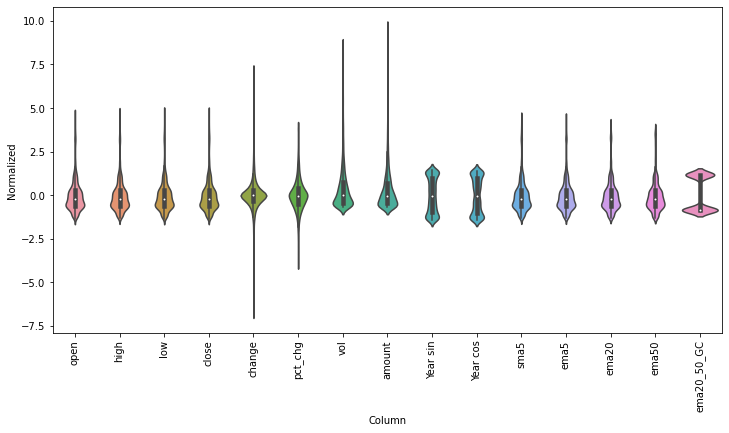

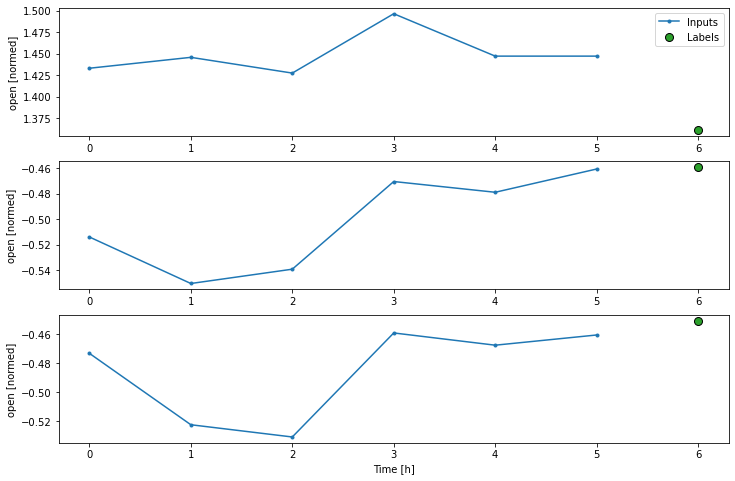

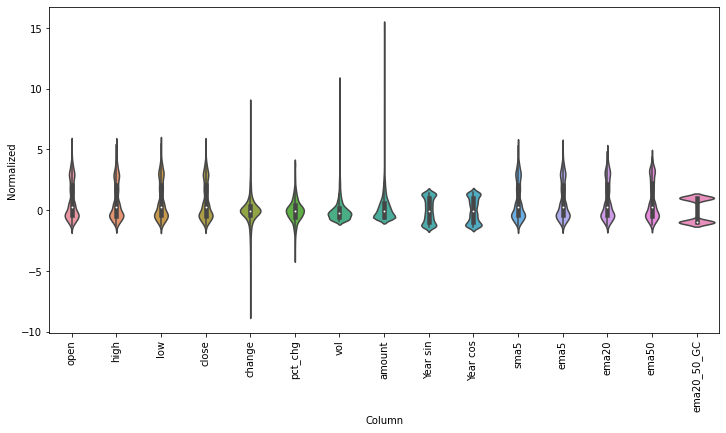

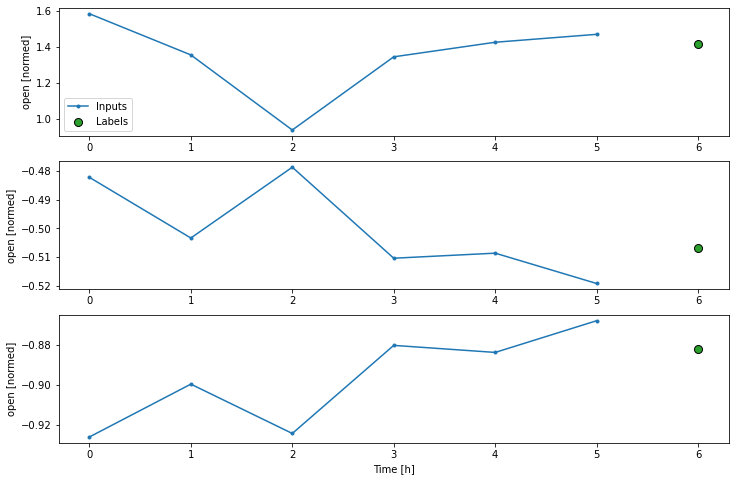

In [24]:
#main training loop
stock_training_range = 20 #len(stock_list)

for stock_index in range( stock_training_range ):

    #set up

    current_stock = stock_list[stock_index] #df

    column_indices = {name: i for i, name in enumerate(current_stock.columns)}

    n = len(current_stock)
    num_features = current_stock.shape[1]
    num_row = current_stock.shape[0]

    #split training, cross val and testing data
    #note since this is a time series data, the split is fixed. No randomization
    #no testing data, only cross val data

    train_data_p = 0.7  #percentage of train data
    val_data_p = 0.2

    train_df = current_stock[ 0 : int(n * train_data_p) ]
    val_df = current_stock[int( n * train_data_p) : int(n * (train_data_p + val_data_p)) ]
    test_df = current_stock[int( n * (train_data_p + val_data_p)) : ]


    #debug area
    ########################################################################
    if debug_mode and stock_index < debug_output_n :
        print("df instances : ", num_row)
        print("df features : ", num_features)
        display(current_stock)


    if debug_mode and stock_index < debug_output_n : 
        print("train_df instances : ", len(train_df))
        display(train_df)
        
        for x in range(4): 
            print()
            
        print("val_df instances : ", len(val_df))
        display(val_df)
        
        for x in range(4): 
            print()
            
        print("val_df instances : ", len(test_df))
        display(test_df)
    ########################################################################


    #normalize data
    train_mean = train_df.mean()
    train_std = train_df.std()

    #compute the z score to normalize data between features
    train_df = (train_df - train_mean)/train_std
    val_df = (val_df - train_mean)/train_std
    test_df = (test_df - train_mean)/train_std


    #visuliazation
    ########################################################################
    if debug_mode and stock_index < debug_output_n :
        df_std = (current_stock - train_mean) / train_std
        df_std = df_std.melt(var_name='Column', value_name='Normalized')
        plt.figure(figsize=(12, 6))
        ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
        _ = ax.set_xticklabels(current_stock.keys(), rotation=90)
    ########################################################################



    #window setup area
    ##############################################################################################

    #set up the 7 timesteps window
    win_7 = time_window_generator(input_width = 6, label_width = 1, shift = 1, train_df=train_df, val_df=val_df, test_df=test_df, label_columns = labels)
    #set up the batch size
    win_7.batch_size = 8

    if debug_mode and stock_index < debug_output_n :
        print(win_7)
        aux_functions.window_inspection(win_7, debug_mode, labels)
    

    ##############################################################################################


    #chose model to run and evaluate
    train_target = win_7
    train_model = stacked_lstm_1



    #individual stock model performance evaluate 

    result = []

    #train models for n numbers of iteration to check the performance
    for iter in range(eval_iteration):

        data_model = aux_functions.compile_and_fit(train_model, train_target, epochs=20, es_patience=4, es_monitor='val_loss', es_mode='min')

        result.append([train_model.evaluate(train_target.val), train_model.evaluate(train_target.test)])
    

    average_mape_val = 0
    average_mape_test = 0
    
    for result_i in range(len(result)):
        average_mape_val += result[result_i][0][1]
        average_mape_test += result[result_i][1][1]
    
    average_mape_val = average_mape_val/len(result)
    average_mape_test = average_mape_test/len(result)



    evaluation_result[stock_list[stock_index].name] = [average_mape_val, average_mape_test, result]



    #data logging

    if performance_log == True:

        performance_log_csv = open(data_log_csv_path, 'a', encoding='UTF8', newline='')
        csv_writer = csv.writer(performance_log_csv)
        csv_writer.writerow([stock_list[stock_index].name, average_mape_val, average_mape_test, eval_iteration, len(train_df), len(val_df), len(test_df), train_model.name])
        performance_log_csv.close()



In [25]:
#check all output of the dictionaries db

for key, value in evaluation_result.items():
    print("Stock Model for : ", key)
    print("Average MAPE of val data_set : ", value[0])
    print("Average MAPE of test data_set : ", value[1])
    print()

Stock Model for :  000001.SZ
Average MAPE of val data_set :  43.858889770507815
Average MAPE of test data_set :  45.51670665740967

Stock Model for :  000002.SZ
Average MAPE of val data_set :  4.015492558479309
Average MAPE of test data_set :  4.286637246608734

Stock Model for :  000008.SZ
Average MAPE of val data_set :  17.1207124710083
Average MAPE of test data_set :  11.913241529464722

Stock Model for :  000009.SZ
Average MAPE of val data_set :  18.728839588165282
Average MAPE of test data_set :  27.879831504821777

Stock Model for :  000027.SZ
Average MAPE of val data_set :  3.720398211479187
Average MAPE of test data_set :  29.768673515319826

Stock Model for :  000039.SZ
Average MAPE of val data_set :  39.73164806365967
Average MAPE of test data_set :  52.106204414367674

Stock Model for :  000046.SZ
Average MAPE of val data_set :  46.901301097869876
Average MAPE of test data_set :  5.101534509658814

Stock Model for :  000060.SZ
Average MAPE of val data_set :  27.6432861328125

In [26]:

# header = ["stock_code","Average MAPE of val data_set", "Average MAPE of test data_set", "Iteration_number"]

# with open("training_log/simple_models.csv", 'w', encoding='UTF8', newline='') as file:

#     writer = csv.writer(file)

#     writer.writerow(header)

#     for key, value in evaluation_result.items():
#         writer.writerow([key, value[0], value[1]])